# Line Follower - CompRobo17

This notebook will show the general procedure to use our project data directories and how to do a regression task using convnets

## Imports and Directories

In [17]:
#Create references to important directories we will use over and over
import os, sys

In [2]:
#import modules
import numpy as np
from glob import glob
from PIL import Image
from tqdm import tqdm
from scipy.ndimage import zoom

from keras.models import Sequential
from keras.metrics import categorical_crossentropy, categorical_accuracy
from keras.layers.convolutional import *
from keras.preprocessing import image
from keras.layers.core import Flatten, Dense
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


In [3]:
import bcolz

Create paths to data directories

In [86]:
DATA_HOME_DIR = '/home/nathan/olin/spring2017/line-follower/line-follower/data'
%cd $DATA_HOME_DIR

path = DATA_HOME_DIR
train_path=path + '/qea-square_2'#+ '/sun_apr_16_office_full_line_1'
valid_path=path + '/qea-square_3'#+ '/sun_apr_16_office_full_line_2'

/home/nathan/olin/spring2017/line-follower/line-follower/data


## Helper Functions

Throughout the notebook, we will take advantage of helper functions to cleanly process our data.

In [5]:
def resize_vectorized4D(data, new_size=(64, 64)):
    """
    A vectorized implementation of 4d image resizing
    
    Args:
        data (4D array): The images you want to resize
        new_size (tuple): The desired image size
        
    Returns: (4D array): The resized images
    """
    fy, fx = np.asarray(new_size, np.float32) / data.shape[1:3]
    return zoom(data, (1, fy, fx, 1), order=1) # order is the order of spline interpolation

In [6]:
def lowerHalfImage(array):
    """ 
    Returns the lower half rows of an image
    
    Args: array (array): the array you want to extract the lower half from
    
    Returns: The lower half of the array
    """
    return array[round(array.shape[0]/2):,:,:]

In [7]:
def folder_to_numpy(image_directory_full):
    """
    Read sorted pictures (by filename) in a folder to a numpy array. 
    We have hardcoded the extraction of the lower half of the images as
    that is the relevant data
    
    USAGE:
        data_folder = '/train/test1'
        X_train = folder_to_numpy(data_folder)
    
    Args:
        data_folder (str): The relative folder from DATA_HOME_DIR
        
    Returns:
        picture_array (np array): The numpy array in tensorflow format
    """
    # change directory
    print ("Moving to directory: " + image_directory_full)
    os.chdir(image_directory_full)
    
    # read in filenames from directory
    g = glob('*.png')
    if len(g) == 0:
        g = glob('*.jpg')
    print ("Found {} pictures".format(len(g)))
    
    # sort filenames
    g.sort()
    
    # open and convert images to numpy array - then extract the lower half of each image
    print("Starting pictures to numpy conversion")
    picture_arrays = np.array([lowerHalfImage(np.array(Image.open(image_path))) for image_path in g])
    
#     reshape to tensorflow format
#     picture_arrays = picture_arrays.reshape(*picture_arrays.shape, 1)
    print ("Shape of output: {}".format(picture_arrays.shape))
    
    # return array
    return picture_arrays
    return picture_arrays.astype('float32')

In [8]:
def flip4DArray(array):
    """ Produces the mirror images of a 4D image array """
    return array[..., ::-1,:] #[:,:,::-1] also works but is 50% slower

In [9]:
def concatCmdVelFlip(array):
    """ Concatentaes and returns Cmd Vel array """
    return np.concatenate((array, array*-1)) # multiply by negative 1 for opposite turn

In [10]:
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

In [11]:
def load_array(fname):
    return bcolz.open(fname)[:]

## Data

Because we are using a CNN and unordered pictures, we can flip our data and concatenate it on the end of all training and validation data to make sure we don't bias left or right turns.

### Training Data

Extract and store the training data in X_train and Y_train

In [21]:
%cd $train_path
Y_train = np.genfromtxt('cmd_vel.csv', delimiter=',')[:,1] # only use turning angle
Y_train = np.concatenate((Y_train, Y_train*-1))
X_train = folder_to_numpy(train_path + '/raw')
X_train = np.concatenate((X_train, flip4DArray(X_train)))

/home/nathan/olin/spring2017/line-follower/line-follower/data/qea-square_2
Moving to directory: /home/nathan/olin/spring2017/line-follower/line-follower/data/qea-square_2/raw
Found 259 pictures
Starting pictures to numpy conversion
Shape of output: (259, 240, 640, 3)


Test the shape of the arrays:  
X_train: (N, 240, 640, 3)  
Y_train: (N,)

In [22]:
X_train.shape, Y_train.shape

((518, 240, 640, 3), (518,))

Visualize the training data, currently using a hacky method to display the numpy matrix as this is being run over a remote server and I can't view new windows

/tmp


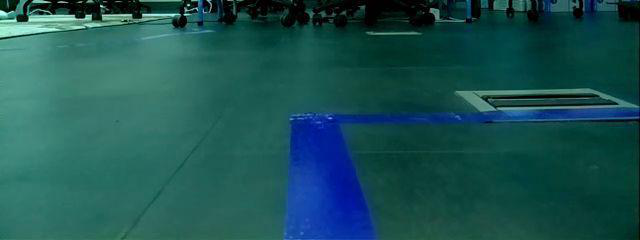

In [23]:
%cd /tmp
img = Image.fromarray(X_train[0], 'RGB')
img.save("temp.jpg")
image.load_img("temp.jpg")

### Validation Data

Follow the same steps for as the training data for the validation data.

In [24]:
%cd $valid_path
Y_valid = np.genfromtxt('cmd_vel.csv', delimiter=',')[:,1]
Y_valid = np.concatenate((Y_valid, Y_valid*-1))
X_valid = folder_to_numpy(valid_path + '/raw')
X_valid = np.concatenate((X_valid, flip4DArray(X_valid)))

/home/nathan/olin/spring2017/line-follower/line-follower/data/qea-square_3
Moving to directory: /home/nathan/olin/spring2017/line-follower/line-follower/data/qea-square_3/raw
Found 95 pictures
Starting pictures to numpy conversion
Shape of output: (95, 240, 640, 3)


Test the shape of the arrays:  
X_valid: (N, 240, 640, 3)  
Y_valid: (N,)

In [25]:
X_valid.shape, Y_valid.shape

((190, 240, 640, 3), (190,))

### Resize Data

When we train the network, we don't want to be dealing with (240, 640, 3) images as they are way too big. Instead, we will resize the images to something more managable, like (64, 64, 3) or (128, 128, 3). In terms of network predictive performance, we are not concerned with the change in aspect ratio, but might want to test a (24, 64, 3) images for faster training

In [26]:
img_rows, img_cols = (64, 64)

In [27]:
print(img_rows)
print(img_cols)

64
64


In [28]:
X_train = resize_vectorized4D(X_train, (img_rows, img_cols))
X_valid = resize_vectorized4D(X_valid, (img_rows, img_cols))

In [29]:
print(X_train.shape)
print(X_valid.shape)

(518, 64, 64, 3)
(190, 64, 64, 3)


Visualize newly resized image.

/tmp


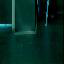

In [30]:

%cd /tmp
img = Image.fromarray(X_train[np.random.randint(0, X_train.shape[0])], 'RGB')
img.save("temp.jpg")
image.load_img("temp.jpg")

### Batches

gen allows us to normalize and augment our images. We will just use it to rescale the images.

In [31]:
gen = image.ImageDataGenerator(
#                                 rescale=1. / 255 # normalize data between 0 and 1
                              )

Next, create the train and valid generators, these are shuffle and have a batch size of 32 by default

In [32]:
train_generator = gen.flow(X_train, Y_train)#, batch_size=batch_size, shuffle=True)
valid_generator = gen.flow(X_valid, Y_valid)#, batch_size=batch_size, shuffle=True)

# get_batches(train_path, batch_size=batch_size, 
#                             target_size=in_shape, 
#                             gen=gen)
# val_batches   = get_batches(valid_path, batch_size=batch_size, 
#                             target_size=in_shape, 
#                             gen=gen)

Shape of data: (64, 64, 3)
/tmp


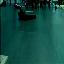

In [33]:
data, category = next(train_generator)
print ("Shape of data: {}".format(data[0].shape))
%cd /tmp
img = Image.fromarray(data[np.random.randint(0, data.shape[0])].astype('uint8'), 'RGB')
img.save("temp.jpg")
image.load_img("temp.jpg")

## Convnet

### Constants

In [34]:
in_shape = (img_rows, img_cols, 3)

### Model

Our test model will use a VGG like structure with a few changes. We are removing the final activation function. We will also use either mean_absolute_error or mean_squared_error as our loss function for regression purposes.

In [72]:
def get_model():
    model = Sequential([
        Convolution2D(32,3,3, border_mode='same', activation='relu', input_shape=in_shape),
        MaxPooling2D(),
        Convolution2D(64,3,3, border_mode='same', activation='relu'),
        MaxPooling2D(),
        Convolution2D(128,3,3, border_mode='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(2048, activation='relu'),
        Dense(1024, activation='relu'),
        Dense(512, activation='relu'),
        Dense(1)
        ])
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

In [73]:
model = get_model()

In [74]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_10 (Convolution2D) (None, 64, 64, 32)    896         convolution2d_input_4[0][0]      
____________________________________________________________________________________________________
maxpooling2d_10 (MaxPooling2D)   (None, 32, 32, 32)    0           convolution2d_10[0][0]           
____________________________________________________________________________________________________
convolution2d_11 (Convolution2D) (None, 32, 32, 64)    18496       maxpooling2d_10[0][0]            
____________________________________________________________________________________________________
maxpooling2d_11 (MaxPooling2D)   (None, 16, 16, 64)    0           convolution2d_11[0][0]           
___________________________________________________________________________________________

### Train

In [71]:
history = model.fit_generator(train_generator, 
                    samples_per_epoch=train_generator.n,
                    nb_epoch=150,
                    validation_data=valid_generator,
                    nb_val_samples=valid_generator.n,
                    verbose=True)

Epoch 1/150
518/518 [==============================] - 0s - loss: 23.7471 - val_loss: 0.1020
Epoch 2/150
518/518 [==============================] - 0s - loss: 0.0951 - val_loss: 0.0916
Epoch 3/150
518/518 [==============================] - 0s - loss: 0.0786 - val_loss: 0.1243
Epoch 4/150
518/518 [==============================] - 0s - loss: 0.0678 - val_loss: 0.1059
Epoch 5/150
518/518 [==============================] - 0s - loss: 0.0487 - val_loss: 0.1113
Epoch 6/150
518/518 [==============================] - 0s - loss: 0.0433 - val_loss: 0.1199
Epoch 7/150
518/518 [==============================] - 0s - loss: 0.0447 - val_loss: 0.1207
Epoch 8/150
518/518 [==============================] - 0s - loss: 0.0401 - val_loss: 0.1264
Epoch 9/150
518/518 [==============================] - 0s - loss: 0.0357 - val_loss: 0.1218
Epoch 10/150
288/518 [===============>..............] - ETA: 0s - loss: 0.0360

KeyboardInterrupt: 

In [57]:
# %cd $DATA_HOME_DIR
# model.save_weights('epoche_150_square.h5')

/home/nathan/olin/spring2017/line-follower/line-follower/data


In [75]:
%cd $DATA_HOME_DIR
model.load_weights('epoche_2500.h5')

/home/nathan/olin/spring2017/line-follower/line-follower/data


### Visualize Training

In [50]:
val_plot = np.convolve(history.history['val_loss'], np.repeat(1/10, 10), mode='valid')
train_plot = np.convolve(history.history['loss'], np.repeat(1/10, 10), mode='valid')

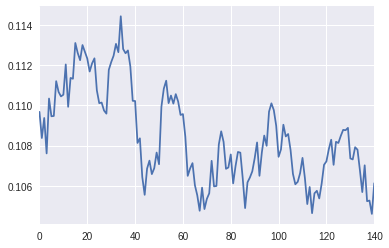

In [55]:
sns.tsplot(val_plot)

In [76]:
X_preds = model.predict(X_valid).reshape(X_valid.shape[0],)
for i in range(len(X_valid)):
    print("{:07f} | {:07f}".format(Y_valid[i], X_preds[i]))

-0.000000 | 0.000023
-0.000000 | 0.000248
-0.000000 | -0.062274
-0.000000 | -0.039846
-0.000000 | -0.034767
-0.021652 | -0.076689
-0.031636 | -0.045172
-0.000000 | -0.038887
-0.000000 | -0.033863
-0.000000 | 0.000343
0.049128 | 0.005424
0.151478 | 0.000525
0.178935 | -0.041115
0.233858 | 0.042791
0.261315 | 0.003587
0.193911 | 0.011053
0.173942 | 0.003587
0.119028 | 0.069693
0.084074 | 0.000343
0.014183 | 0.000343
-0.000000 | 0.000343
0.029159 | -0.041461
0.001702 | -0.041461
-0.000000 | 0.000379
-0.000000 | 0.000379
-0.000000 | 0.000343
-0.000000 | 0.036479
-0.000000 | 0.001080
-0.000000 | -0.048218
0.046632 | 0.009877
0.300000 | 0.043255
0.300000 | 0.041751
0.300000 | 0.041751
0.300000 | -0.079364
0.300000 | -0.052325
0.300000 | 0.092927
-0.000000 | 0.044087
-0.000000 | -0.000495
-0.099040 | -0.055633
-0.044117 | 0.000343
-0.000000 | -0.016230
-0.000000 | -0.078628
-0.000000 | 0.000347
-0.000000 | -0.010777
-0.000000 | 0.060072
-0.000000 | 0.071711
0.104052 | 0.060775
0.096564 | 0.01

In [77]:
X_train_preds = model.predict(X_train).reshape(X_train.shape[0],)
for i in range(len(X_train_preds)):
    print("{:07f} | {:07f}".format(Y_train[i], X_train_preds[i]))

-0.000000 | 0.000343
-0.000000 | 0.000343
-0.000000 | 0.042263
0.006695 | 0.000851
-0.000000 | 0.000343
-0.000000 | 0.000918
-0.000000 | 0.000343
-0.000000 | 0.000343
-0.000000 | 0.013546
-0.006675 | 0.013546
-0.300000 | -0.000280
-0.300000 | -0.000280
-0.300000 | -0.008237
-0.300000 | 0.023744
-0.300000 | 0.003587
-0.000000 | -0.064452
-0.000000 | -0.028688
-0.151458 | -0.028688
-0.041621 | 0.000343
0.006695 | 0.000485
-0.000000 | 0.044193
-0.000000 | 0.064389
-0.000000 | 0.002993
0.046632 | 0.009014
-0.000000 | 0.000343
-0.000000 | 0.000343
-0.009171 | 0.001085
-0.300000 | -0.000092
-0.300000 | 0.001086
-0.091552 | 0.042219
-0.223855 | 0.062609
-0.273777 | -0.036530
-0.221359 | -0.001348
-0.000000 | -0.000856
-0.000000 | 0.000519
-0.034132 | 0.001065
-0.061589 | -0.026303
-0.041621 | -0.005071
-0.000000 | 0.000387
-0.000000 | -0.000296
-0.000000 | 0.000447
-0.000000 | -0.000097
-0.000000 | 0.000343
-0.000000 | 0.000301
-0.000000 | 0.000158
-0.041621 | 0.012068
-0.071574 | 0.010476
-0

Notes
* 32 by 32 images are too small resolution for regression
* 64 by 64 seemed to work really well
* Moving average plot to see val_loss over time is really nice
* Can take up to 2000 epochs to reach a nice minimum

In [78]:
X_preds.shape

(190,)

In [ ]:
X_train_preds.shape

In [ ]:
np.savetxt("X_train_valid.csv", X_preds, fmt='%.18e', delimiter=',', newline='\n')
np.savetxt("X_train_preds.csv", X_train_preds, fmt='%.18e', delimiter=',', newline='\n')

## Layer play

In [79]:
len(model.layers)

11

In [80]:
model.pop()

In [81]:
len(model.layers)

10

In [82]:
model.compile(loss='mean_absolute_error', optimizer='adam')

In [83]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_10 (Convolution2D) (None, 64, 64, 32)    896         convolution2d_input_4[0][0]      
____________________________________________________________________________________________________
maxpooling2d_10 (MaxPooling2D)   (None, 32, 32, 32)    0           convolution2d_10[0][0]           
____________________________________________________________________________________________________
convolution2d_11 (Convolution2D) (None, 32, 32, 64)    18496       maxpooling2d_10[0][0]            
____________________________________________________________________________________________________
maxpooling2d_11 (MaxPooling2D)   (None, 16, 16, 64)    0           convolution2d_11[0][0]           
___________________________________________________________________________________________

In [84]:
X_train_features = model.predict(X_train)
X_valid_features = model.predict(X_valid)

In [87]:
%cd $train_path
save_array("X_train_features.b", X_train_features)

/home/nathan/olin/spring2017/line-follower/line-follower/data/qea-square_2


In [88]:
%cd $valid_path
save_array("X_train_features.b", X_valid_features)

/home/nathan/olin/spring2017/line-follower/line-follower/data/qea-square_3


In [66]:
X_train_features[9]

array([  5.33585669e-03,   1.66742444e-01,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   6.98533207e-02,
         4.81044203e-02,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   5.29092811e-02,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   6.03598133e-02,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.43573746e-01,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.31637305e-01,   0.00000000e+00,
         1.29797995e-01,   4.59849834e-03,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.19216651e-01,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.15265340e-01,   0.00000000e+00,   0.00000000e+00,
         1.74763855e-02,

In [ ]:
def get_model_lstm():
    model = Sequential([
        Convolution2D(32,3,3, border_mode='same', activation='relu', input_shape=in_shape),
        MaxPooling2D(),
        Convolution2D(64,3,3, border_mode='same', activation='relu'),
        MaxPooling2D(),
        Convolution2D(128,3,3, border_mode='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(2048, activation='relu'),
        Dense(1024, activation='relu'),
        Dense(512, activation='relu'),
        Dense(1)
        ])
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model